# Classifying Fashion-MNIST

* 이번 실습에서는 지난 시간과 거의 유사한 작업을 Fashion-MNIST dataset에 대해서 수행하겠습니다

* Fashion-MNIST 는 28x28 흑백으로 된 의류 image입니다
* 숫자를 표현한 MNIST 보다는 더 복잡한 image가 되어, NN의 성능을 시험해보기 조금 더 난해한 dataset 입니다 (물론 지금 시대에는 여전히 쉬운 작업입니다)

* dataset에 대한 그림은 아래와 같습니다


![Classnote](https://drive.google.com/uc?export=download&id=1jS383QGptWGFyDrVO0i8Eo7BwXqV5epq)

* 작업은 여러분이 처음부터 끝까지 코딩을 하시면 됩니다
* 전체적인 흐름은 지난 주 숙제와 동일하기 때문에 (결국 10개의 의상 종류로 분류합니다) 지난 주 숙제 solution이나 본인이 짠 부분을 대부분 가져와서 해보시면 됩니다.

* 아래는 dataset을 준비하는 과정입니다

In [1]:
import torch
from torchvision import datasets, transforms
import helper

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000, shuffle=True)  # 배치를 크게 가져와야 평균값이 잘 나올 것이다.

In [3]:
images, labels = next(iter(trainloader))

In [4]:
images.shape  # 배치 2000 / 흑백이어서 1

torch.Size([2000, 1, 28, 28])

In [5]:
torch.mean(images)  # 전체 데이터에 대한 평균

tensor(0.2839)

In [6]:
torch.std(images)  # 전체 데이터에 대한 표준편차

tensor(0.3511)

In [7]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [8]:
torch.cuda.is_available()

False

In [9]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.28,), (0.35,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data -> test set에 대해서 validation set으로 사용
valset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# validation set에 대한 데이터 loader
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) 

* 아래 명령으로 이미지 중에 한개를 살펴봐서 준비가 되었는지 확인해 봅시다

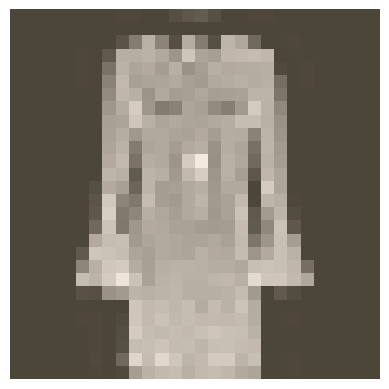

In [10]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

### Problem 1

* 이미지가 28x28인 점을 고려하여 지난주에 벡터로 변환하는 작업을 수행하고
* fc1,...,fc4 까지 linear layer를 만드시고
* 최종 output layer fc4는 10개 분류 작업을 할 수 있도록 구성

* Activation 함수는 ReLU, 최종 layer는 linear layer 만 연산
* Cost function 정의
* autograd, optimizer를 사용하여 training 수행 
* fc1 는 256의 크기로 구성
* fc2 는 128의 크기로 구성
* fc3 는 64의 크기로 구성
* epoch수는 5

In [11]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    ###############

### Problem 2: Training the network

In [12]:
# TODO: 네트워크를 training 하세요 (epoch는 5번으로 하죠)

model = Classifier()  # 모델 불러오기
model.to(device)      # cpu / cuda 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)  # Adam : SGD알고리즘의 단점 보완한 버전

epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.reshape(images.shape[0],-1).to(device)  # to(device)로 옮겨줌
        labels = labels.to(device)
        
        #### 답 작성
        logits = model(images)
        loss = criterion(logits, labels)  # loss만드는 과정
        
        optimizer.zero_grad()  # 그래디언트 초기화
        loss.backward()        # 그래디언트 만드는 과정
        optimizer.step()       # SGD 과정 / 그레디언트 업데이트
 
        #### 
        
        running_loss += loss.item()
    
    print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.482733444793265
Training loss: 0.37179681795365266
Training loss: 0.3388181400737529
Training loss: 0.31446455228430376
Training loss: 0.29755596749023844


#### validation set으로 검증해보기

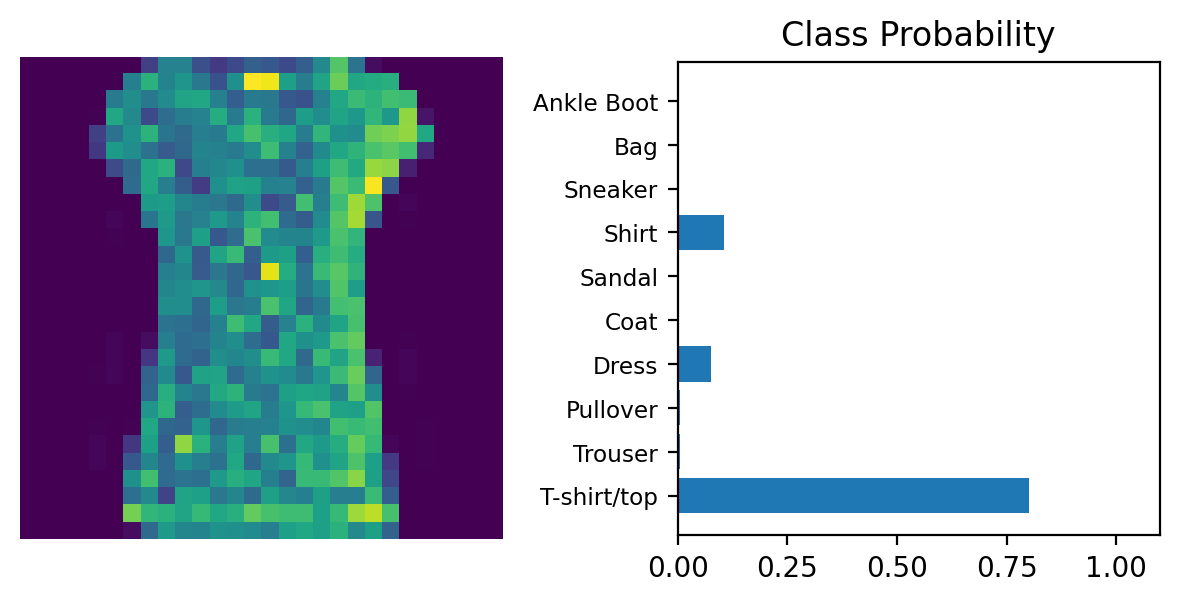

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out your network!

images, labels = next(iter(valloader))
img = images[1].reshape(1,-1)
img = img.to(device)  # 꼭 해주기!!

# log softmax 값을 softmax로 변환하여 확률값을 저장
logits = model(img)     # row별로 logits를 저장하고 있음(모델 예측값)
sm = nn.Softmax(dim=1)  # 각 샘플에 대한 확률값 저장(row별로 적용 dim = 1)
ps = sm(logits)

# Plot the image and probabilities
helper.view_classify(img.to('cpu'), ps.cpu(), version='Fashion')

# Part 2: Inference and Validation

* 지금까지는 network를 training하는 방법에 대해서 알아보았습니다
* Training 된 network를 활용하여 예측 (prediction)을 하는 것을 ML 용어로 inference라고 합니다
* Training된 network를 새로운 데이터에 대해서도 좋은 성능을 갖게하는 것을 generalization 이라고 합니다 
* 하지만, neural network (또는 모든 ML)은  training 된 데이터에 너무 최적화되어, 새로운 데이터에대해서 성능이 떨어지는 (generalization 이 안되는) 문제가 발생합니다. 이런 현상을  **overfitting** 이라고 합니다
* **Generalization** 이 잘되어서 **overfitting** 안일어났는지 확인하는 작업을 **validation** set으로 data를 분리하여 수행합니다
* Overfitting이 일어나지 않도록 처리하는 여러 기법을 **regularization** 이라고 하며, 대표적으로 **dropout**과 같은것이 있습니다
* 이번 실습에서는 **validation**에 대해서 알아보겠습니다

* dataset 은 torchvision을 통해서 load하겠습니다
* Torchvision에 대한 자세한 기능은 차차 배우기로 학고, 우선은 테스트 세트를 load하기 위해서 `train=False` 로 설정합니다

```python
valset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

* validation set은 trainging set과 비슷한 구조를 갖습니다

* 본 작업에 목적은 training set에 포함하지 않은 data에 대해서 성능을 측정하는 것입니다
* 여기서 성능은 개발자에 의해서 용도에 맞게 설정합니다 
* 본 과제에서는 정확도 관점에서 성능을 측정학겠습니다
  - 즉 분류를 성공과 실패로 보고 성공의 비율을 측정합니다
* 기타 성능 측정을 위한 방법은 [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) 과 top-5 error rate 등이 있습니다
* 시작으로, 한개에 batch에 대한 forward pass를 실행합니다

In [25]:
model = Classifier()

images, labels = next(iter(valloader))

# Get the class probabilities
images = images.reshape(images.shape[0],-1)
logits = model(images)
ps = sm(logits)  # softmax적용한 것
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)  # 배치 64개 , output은 10개의 class

# 각 row에서 (col이)0번class일 확률, 1번 class일 확률, ...

torch.Size([64, 10])


* 출력은 각 classification 항목에 대한 확률 분포로 출력됩니다
* `ps.topk` method로 $k$개의 활률 값이 가장 높은 value와 index를 tuple로 받습니다
* 가장 높은 가능성으로 분류를 하고자하니, `ps.topk(1)`를 사용합니다
* 예를 들어서 가장 높은 value가 5번째이면 index 4를 받습니다

In [27]:
# 가장 높은 값 1개를 뽑는 것. (row별로->dim=1)
top_p, top_class = ps.topk(1, dim=1)  # 가장 높은 값과 class 번호를 받는다.
# Look at the most likely classes for the first 10 examples
print(top_p[:10,:])
print(top_class[:10,:])
top_class.shape

tensor([[0.1123],
        [0.1114],
        [0.1080],
        [0.1083],
        [0.1105],
        [0.1095],
        [0.1095],
        [0.1109],
        [0.1083],
        [0.1081]], grad_fn=<SliceBackward0>)
tensor([[9],
        [9],
        [9],
        [4],
        [9],
        [9],
        [3],
        [9],
        [9],
        [4]])


torch.Size([64, 1])

In [28]:
ps[:10,:]

tensor([[0.0998, 0.0970, 0.0921, 0.1035, 0.1061, 0.0896, 0.1037, 0.0958, 0.1002,
         0.1123],
        [0.0984, 0.0978, 0.0937, 0.1053, 0.1062, 0.0918, 0.1000, 0.0976, 0.0978,
         0.1114],
        [0.0979, 0.1034, 0.0968, 0.1037, 0.1032, 0.0893, 0.1058, 0.0931, 0.0987,
         0.1080],
        [0.0982, 0.0971, 0.0984, 0.1038, 0.1083, 0.0882, 0.0994, 0.1014, 0.0995,
         0.1057],
        [0.1000, 0.0987, 0.0941, 0.1022, 0.1071, 0.0877, 0.1028, 0.0959, 0.1011,
         0.1105],
        [0.1014, 0.0970, 0.0933, 0.1029, 0.1065, 0.0868, 0.1061, 0.0968, 0.0997,
         0.1095],
        [0.0981, 0.0962, 0.0953, 0.1095, 0.1018, 0.0921, 0.1019, 0.0982, 0.0975,
         0.1094],
        [0.0992, 0.0988, 0.0951, 0.1020, 0.1058, 0.0899, 0.1037, 0.0955, 0.0992,
         0.1109],
        [0.0987, 0.0989, 0.0940, 0.1018, 0.1082, 0.0888, 0.1078, 0.0937, 0.0997,
         0.1083],
        [0.0973, 0.0969, 0.0947, 0.1077, 0.1081, 0.0880, 0.1017, 0.0974, 0.1010,
         0.1070]], grad_fn=<

* 지금까지 네트워크에서 출력한 확률분포에서 가장 높은 확률값의 index를 64개 찾았습니다
* 이제 `top_class`와 `labels`를 비교하여 몇개를 맞췄는지 확인을 해야합니다
* 차원이 맞는 tensor 간에 `==`를 해서 비교합니다 (테스트 해보세요!)
* 다음을 실행하면 원하는 답이 나오지 않습니다
* `top_class`와 `labels`의 shape를 비교 해보고 싶은 생각이 드셔야합니다
```python
equals = top_class == labels
```
* (참고) broadcasting으로 `==` 연산이 일어난것이며, 우리가 원하는 연산은 아닙니다 

In [29]:
labels.shape

torch.Size([64])

In [30]:
top_class.shape

torch.Size([64, 1])

In [31]:
top_class == labels.reshape(top_class.shape) # top_class의 shape에 맞춰서 reshape!

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

In [32]:
labels

tensor([3, 2, 0, 9, 5, 9, 4, 7, 5, 6, 6, 9, 2, 5, 4, 1, 0, 3, 6, 9, 3, 7, 3, 9,
        5, 7, 4, 6, 2, 4, 7, 4, 6, 9, 6, 4, 7, 4, 0, 2, 1, 5, 0, 8, 5, 2, 0, 5,
        8, 5, 9, 6, 4, 5, 9, 2, 8, 9, 4, 4, 1, 3, 0, 6])

In [33]:
# equals에 저장.
equals = top_class == labels.reshape(top_class.shape)
top_class.shape

torch.Size([64, 1])

* 이제 분류가 성공한 비율을 찾기위해서 전체를 더하고 총수로 나누는 (평균)을 내면됩니다
* `torch.mean`이 유용한데 
* `torch.mean(equals)`를 실행하면

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```
* `equals`를 float tensor로 변환하여 적용합니다


In [34]:
accuracy = torch.mean(equals.type(torch.float))  # equals는 불린값이기 때문에 float로 변경
print(f'Accuracy: {accuracy*100}%')

Accuracy: 6.25%


* 당연히 네트워크가 training이 안되었기 때문에 값이 랜덤하게 나옵니다
* 이제 전체 test data (validation set)에 대한 loop를 완성하려 합니다 (위는 한 batch)
* 아래 Exercise를 수행하는데 중요한 코드가 있습니다
* `torch.no_grad():`는 tensor에 gradient 정보 없이 작업을 할때 사용합니다. 당연히 training이 없으니 network parameter를 업데이트할 필요가 없고, gradient 정보를 저장하는데 쓸데 없는 연산과 메모리 사용을 방지할 수 있습니다. Validation과정에서는 필수입니다! 

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```


In [38]:
# 답 작성
model = Classifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

# train loss와 validation loss를 epoch별로 저장.
train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    
    # 총 샘플이 배치개수만큼 들어있을 것. -> 그것에 대한 loss
    for images, labels in trainloader:
        images = images.reshape(images.shape[0],-1).to(device)
        labels = labels.to(device)
        

        # 답작성: Training 코드 
        
        optimizer.zero_grad()
        
        logits = model(images)
        loss = criterion(logits, labels)  # 초깃값의 loss (아래의 validation loss는 업데이트 된 이후의 loss)
        
        loss.backward()
        optimizer.step()
        
        #######################
        running_loss += loss.item()

        
# validation 과정
# 만약 위에서 첫번째 에폭의 training이 끝났다면, 그것에 대한 validation을 수행한다.
    val_loss = 0
    accuracy = 0

    # validation에서는 성능만 보는것이다. 그래디언트 업데이트 X
    with torch.no_grad():  
        for images, labels in valloader:
            images = images.reshape(images.shape[0], -1).to(device)
            labels = labels.to(device)
            logits = model(images)
            val_loss += criterion(logits, labels).item()
            
            ps = sm(logits)  # 확률값으로 바꿈
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            accuracy += torch.mean(equals.type(torch.float))


            #######################

    train_losses.append(running_loss/len(trainloader))  # running_loss를 배치의 수로 나눈다.
    val_losses.append(val_loss/len(valloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)),
          "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))

Epoch: 1/30..  Training Loss: 0.479..  Validation Loss: 0.421..  Validation Accuracy: 0.851
Epoch: 2/30..  Training Loss: 0.368..  Validation Loss: 0.411..  Validation Accuracy: 0.853
Epoch: 3/30..  Training Loss: 0.331..  Validation Loss: 0.384..  Validation Accuracy: 0.859
Epoch: 4/30..  Training Loss: 0.311..  Validation Loss: 0.404..  Validation Accuracy: 0.862
Epoch: 5/30..  Training Loss: 0.293..  Validation Loss: 0.390..  Validation Accuracy: 0.867
Epoch: 6/30..  Training Loss: 0.283..  Validation Loss: 0.358..  Validation Accuracy: 0.876
Epoch: 7/30..  Training Loss: 0.269..  Validation Loss: 0.364..  Validation Accuracy: 0.875
Epoch: 8/30..  Training Loss: 0.262..  Validation Loss: 0.347..  Validation Accuracy: 0.879
Epoch: 9/30..  Training Loss: 0.254..  Validation Loss: 0.369..  Validation Accuracy: 0.881
Epoch: 10/30..  Training Loss: 0.243..  Validation Loss: 0.388..  Validation Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.239..  Validation Loss: 0.368..  Validation Ac

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

Text(0, 0.5, 'loss')

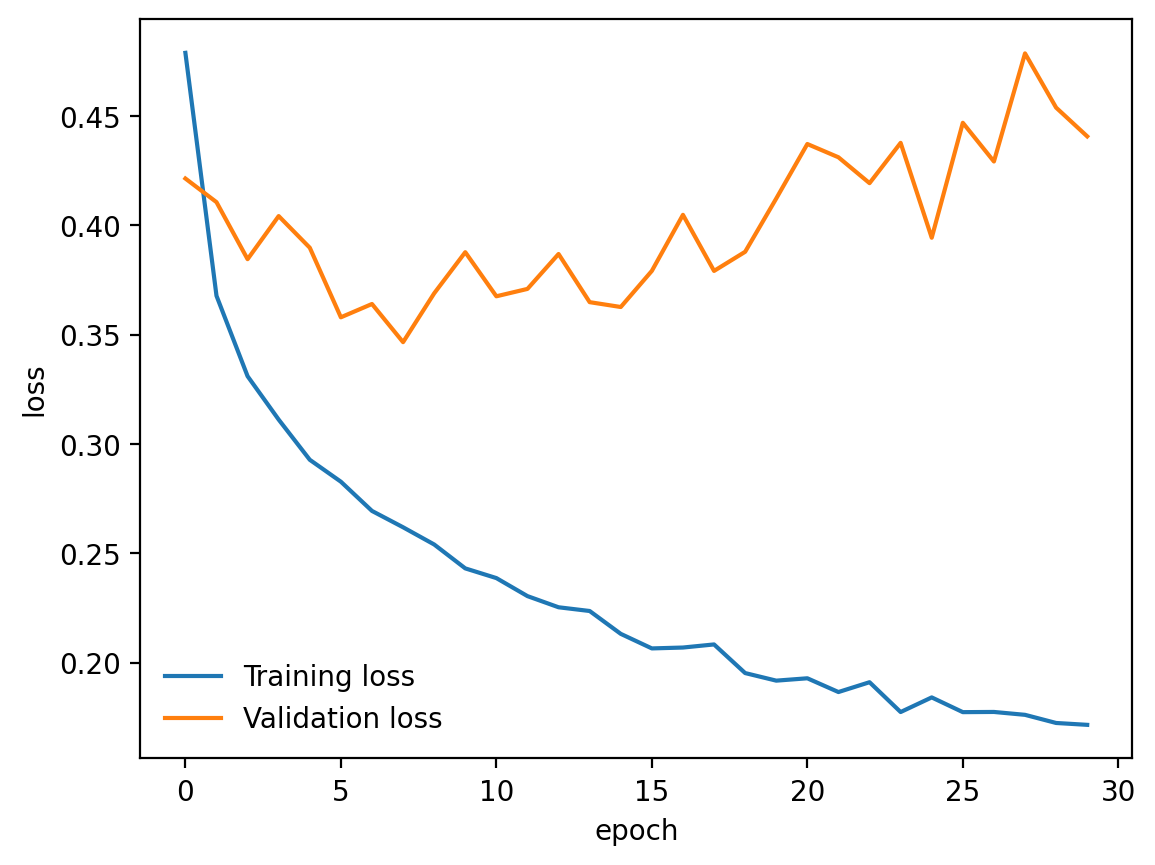

In [40]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss')

## Overfitting

* 위에서 수행한 결과를 살펴보면 overfitting 현상을 확인할 수 있습니다
* 같지는 않지만, 아래와 같은 현상:

![Classnote](https://drive.google.com/uc?export=download&id=1QOvGv2H28H0X94tkUo5VU40TPeSjpI9q)

- Training loss는 점점 줄어드는 반면, validation loss는 일정 줄어들다가 다시 늘어나는 현상을 확인 할 수 있습니다. 
- 궁극적인 목적은 새로운 data에 대해서 잘 동작하는 것이기 때문에 가장 낮은 validation loss를 갖도록 하는것이 목표 입니다
- 그래프에서 착안 할 수 있는 방법중 하나는 가장 낮아지는 epoch를 찾아서 멈추는 방법입니다. 이런 방법을 *early-stopping*이라고 합니다 
- 실제 적용하는 practice에서는 많은 training을 수행하며, 그 중에서 가장 좋은 성능(lowest validation error)의 network을 선택합니다
- Early stopping 이외에 매우 자주 사용되는 regularization 방법은 *dropout* 입니다
- Dropout은 네트워크의 연결을 랜덤하게 일정 비율로 끊어버리는 방법입니다
- Dropout이 왜 효과가 있는지는 이론 수업에서 다루도록 하겠습니다
- Pytorch에서 dropout을 수행하는 방법은 [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module 통해서 합니다

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        self.fc4 = None
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)  # 통상적으로 0.2~0.5의 확률을 넣는 것이 좋다.
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = self.fc4(x)
        
        return x
```

* 여기서 Dropout은 training 단계에서만 사용하고, validation에서는 전체 네트워크를 사용해야 합니다 (Why?)
* 즉, validation 과정에서는 dropout을 비활성화 해야하죠
  - 이를 위해서 `model.eval()`을 사용합니다
  - 즉, `model.eval()` 모드 하에서는 droupout 확률이 0으로 동작합니다   
  - 다시 dropout를 수행할때는 `model.train()`으로 활성화 합니다
  - 일반적으로 아래와 같이 동작하죠
    1. Validation loop에서 gradient를 끄고, model을 evaluation mode로 설정
    2. validation loss를 계산하고 
    3. 다시 train mode로 변경 
    
```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

**Problem 3:** 

- 아래 코드에서 dropout를 사용하기 위한 필요한 곳을 수정/채워 주세요
- model 에 dropout 적용, model.eval, model.train 등
- 아래 코드는 위에 적용했던 코드 problem 1 부분 제외한 모음입니다
- Template이라고 생각학고 적용하시면 됩니다

In [41]:
class Classifier(nn.Module):
    
    # 앞 문제에서 작성한 network에 dropout 적용
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        self.relu = nn.ReLU(True)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        

    def forward(self, x):
        # Now with dropout
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        # 마지막 레이어에 relu를 적용하지 않은 것은 확률 형태의 데이터가 되도록하기 위해서 
        #-> 드롭아웃도 적용X. 뉴런이 사라지면서 class수가 사라짐
        x = self.fc4(x)

        return x
    ##############################

In [44]:
    model = Classifier()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    epochs = 30
    steps = 0

    train_losses, val_losses = [], []
    for e in range(epochs):
        running_loss = 0


        for images, labels in trainloader:
            images = images.reshape(images.shape[0],-1).to(device)
            labels = labels.to(device)


            # training 답 작성 
            optimizer.zero_grad()

            logits = model(images)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()


            #######################
            running_loss += loss.item()


        val_loss = 0
        accuracy = 0

        # Gradient를 계산할 필요 없으니 비활성화 
        with torch.no_grad():
    
            model.eval()  # 드롭 아웃을 끈다.
            for images, labels in valloader:
                images = images.reshape(images.shape[0], -1).to(device)
                labels = labels.to(device)

                logits = model(images)
                val_loss += criterion(logits, labels).item()

                ps = sm(logits)  # 확률값으로 바꿈
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(top_class.shape)
                accuracy += torch.mean(equals.type(torch.float))

                ##################
                
        model.train()   # 다시 드롭아웃 켜준다.(training 과정에서 적용하기 위해)
        
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss/len(valloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))

Epoch: 1/30..  Training Loss: 0.563..  Validation Loss: 0.437..  Validation Accuracy: 0.843
Epoch: 2/30..  Training Loss: 0.453..  Validation Loss: 0.407..  Validation Accuracy: 0.853
Epoch: 3/30..  Training Loss: 0.422..  Validation Loss: 0.400..  Validation Accuracy: 0.860
Epoch: 4/30..  Training Loss: 0.407..  Validation Loss: 0.395..  Validation Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.400..  Validation Loss: 0.380..  Validation Accuracy: 0.866
Epoch: 6/30..  Training Loss: 0.386..  Validation Loss: 0.379..  Validation Accuracy: 0.866
Epoch: 7/30..  Training Loss: 0.381..  Validation Loss: 0.391..  Validation Accuracy: 0.864
Epoch: 8/30..  Training Loss: 0.375..  Validation Loss: 0.374..  Validation Accuracy: 0.867
Epoch: 9/30..  Training Loss: 0.368..  Validation Loss: 0.367..  Validation Accuracy: 0.872
Epoch: 10/30..  Training Loss: 0.362..  Validation Loss: 0.371..  Validation Accuracy: 0.863
Epoch: 11/30..  Training Loss: 0.357..  Validation Loss: 0.406..  Validation Ac

In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

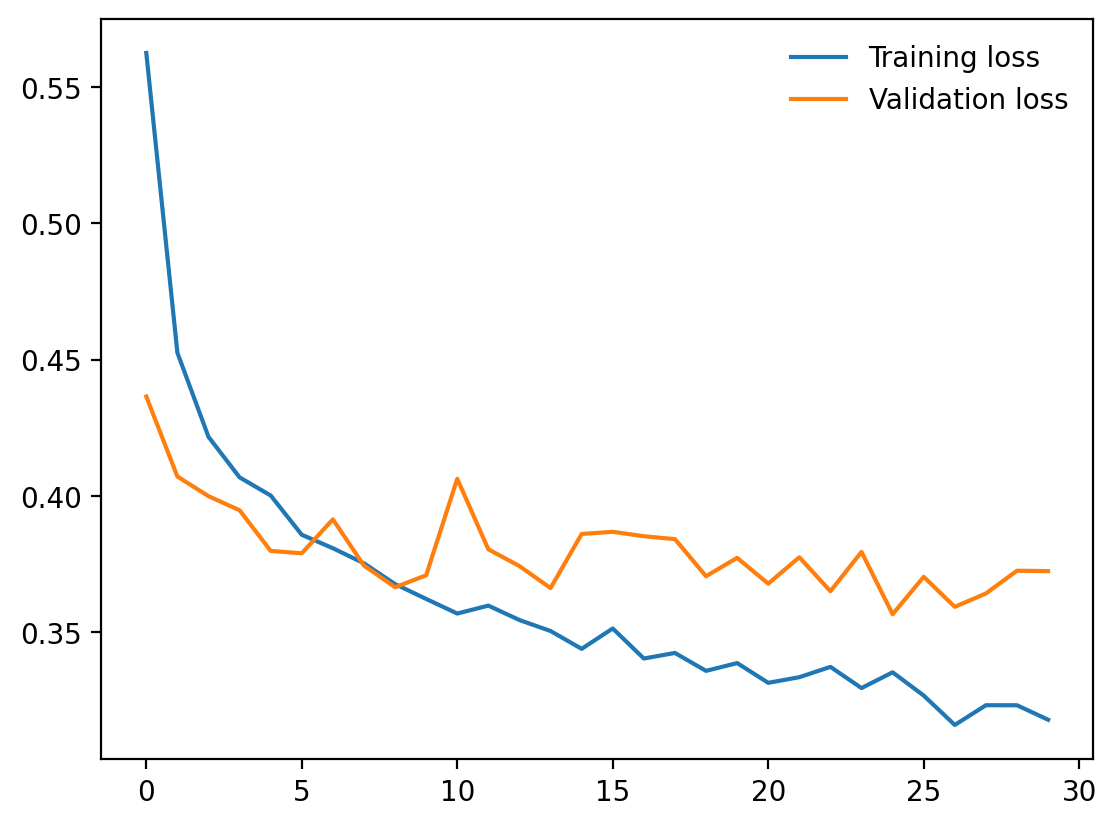

In [46]:
plt.plot(train_losses[:30], label='Training loss')
plt.plot(val_losses[:30], label='Validation loss')
plt.legend(frameon=False)

###### Inference

* 이제 실제 적용하는 예입니다 (inference)
* 내가 분류작업을 한다고 생각학고 traning이 끝난 네트워크에 적용합니다
* 당연히 model.eval()과 gradient는 비활성화합니다

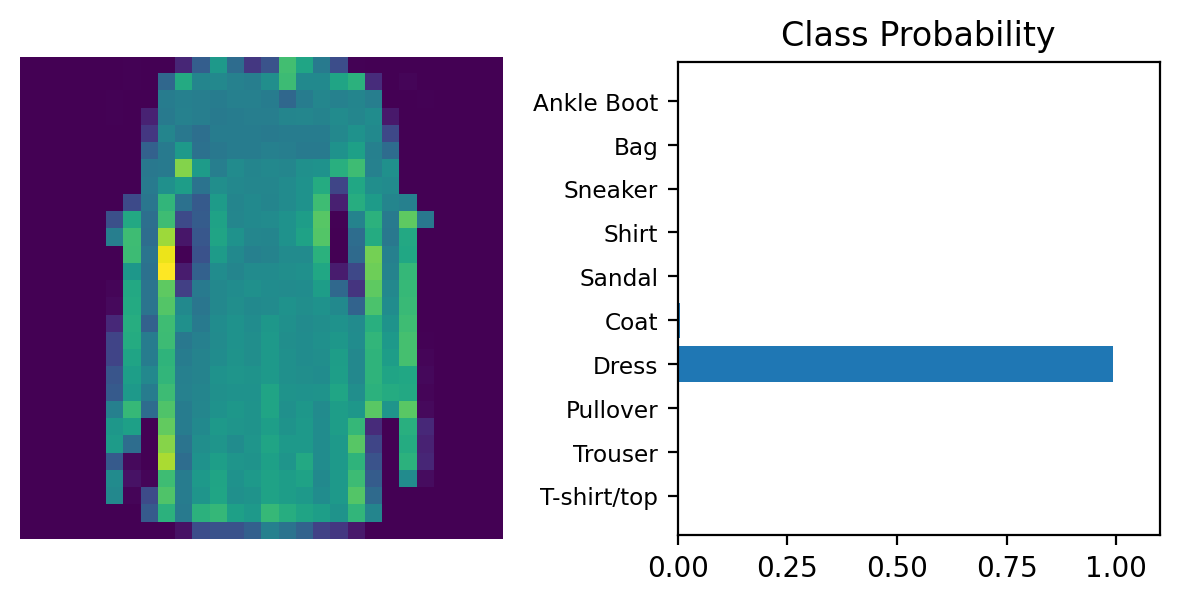

In [48]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(valloader)
images, labels = dataiter.__next__()
images = images.reshape(images.shape[0],-1).to(device)
labels = labels.to(device)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = sm(output)

# Plot the image and probabilities
img = img.cpu()
ps = ps.cpu()
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')